# 10-5. 프로젝트 : 개선된 U-Net 모델 만들기

U-Net을 통한 시맨틱 세그멘테이션 결과가 충분히 만족스러우신가요? 어느 정도 동작하는 것 같긴 하지만 좀 더 개선할 여지도 보일 것입니다.

<br>

2018년에 U-Net++라는 논문이 나왔습니다. 이 논문은 기존에 아주 단순하면서도 세그멘테이션에서 효과를 발휘했던 U-Net의 네트워크 구조에 DenseNet의 아이디어를 가미하여 성능을 개선한 모델입니다. 논문은 2020년에 한 번 업그레이드가 되었네요.

<br>

- [U-Net++: v1](https://arxiv.org/abs/1807.10165)
- [U-Net++: v2](https://arxiv.org/abs/1912.05074)

<br>

모델의 구조 자체는 아래 그림에서 보는 것처럼 별다른 설명이 없이도 직관적으로 이해가 가능한 수준입니다. 오늘 소개되었던 U-Net의 모델 코드를 조금만 수정 확장하면 충분히 구현할 수 있을 것입니다. 그래서 오늘의 과제는 바로 U-Net++ 모델을 스스로의 힘으로 직접 구현해 보고, U-Net을 활용했던 도로 세그멘테이션 태스크에 적용하여 U-Net을 썼을 때보다 성능이 향상되었음을 확인해 보는 것입니다. 정성적으로는 두 모델의 세그멘테이션 결과를 시각화해서 비교해 볼 수 있을 것이고, 정량적으로는 동일 이미지에 대한 IoU 값을 비교해 보면 될 것입니다.

<br>

![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-5-P-UNPP.max-800x600.png)

<br>

참고할 수 있는 코드는 아래에 있습니다. 다행히도 keras로 구현되어 있습니다.

<br>

- [U-Net++:Github](https://github.com/MrGiovanni/UNetPlusPlus)

<br>

코드 중에서 가장 중요한 부분도 알려드리자면 [여기:build_xnet](https://github.com/MrGiovanni/UNetPlusPlus/blob/e145ba63862982bf1099cf2ec11d5466b434ae0b/keras/segmentation_models/xnet/builder.py#L12)입니다. 논문에서 제시하는 수식과 함께 참고하세요.

<br>

![](https://d3s0tskafalll9.cloudfront.net/media/images/gc-5v2-p-4-1.max-800x600.png)

<br>

코드 중 `up_block`으로는 두 가지 방식을 사용하고 있네요. [Transpose2D_block](https://github.com/MrGiovanni/UNetPlusPlus/blob/e145ba63862982bf1099cf2ec11d5466b434ae0b/keras/segmentation_models/xnet/blocks.py#L53)과 [Upsample2D_block](https://github.com/MrGiovanni/UNetPlusPlus/blob/e145ba63862982bf1099cf2ec11d5466b434ae0b/keras/segmentation_models/xnet/blocks.py#L28)인데요. 둘 중 어느 것을 사용해도 좋습니다.

<br>

또 한 가지 주의해야 할 점은 Loss를 조금 다르게 구현해야 한다는 점입니다. binary cross-entropy와 dice coefficient를 사용한다고 하는데요. [dice_coef](https://github.com/MrGiovanni/UNetPlusPlus/blob/e145ba63862982bf1099cf2ec11d5466b434ae0b/keras/helper_functions.py#L37)에 구현된 dice coefficient를 참고해 보세요.

<br>

![](https://d3s0tskafalll9.cloudfront.net/media/images/gc-5v2-p-4-2.max-800x600.png)

<br>

프로젝트 진행에 필요한 주요 라이브러리 버전 체크를 해봅시다.

In [1]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"
!pip uninstall opencv-python-headless
!pip install opencv-python-headless==4.1.2.30

albumentations==1.1.0 is successfully installed
Found existing installation: opencv-python-headless 4.1.2.30
Uninstalling opencv-python-headless-4.1.2.30:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.1.2.30.dist-info/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.7/dist-packages/cv2/.libs/libQtCore-bbdab771.so.4.8.7
    /usr/local/lib/python3.7/dist-packages/cv2/.libs/libQtGui-903938cd.so.4.8.7
    /usr/local/lib/python3.7/dist-packages/cv2/.libs/libQtTest-1183da5d.so.4.8.7
Proceed (y/n)? y
  Successfully uninstalled opencv-python-headless-4.1.2.30
  Using cached opencv_python_headless-4.1.2.30-cp37-cp37m-manylinux1_x86_64.whl (21.8 MB)


In [7]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *


print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(skimage.__version__)
print(albumentations.__version__)

2.8.0
1.21.5
7.1.2
0.18.3
1.1.0


## Step 1. KITTI 데이터셋 수집과 구축
다운로드한 KITTI 데이터에 data augmentation을 적용한 형태로 데이터셋을 구축합니다. 이때 주의할 점이 있습니다. U-Net++는 메모리 사용량이 U-Net보다 꽤 많아집니다. 그러니 배치 사이즈를 적절히 줄여서 설정하시기를 권합니다.

**albumentation 적용**

- `train ds`를 albumentation 적용한 뒤 (224, 224)로 리사이즈한다.
- `test ds`에는 (224, 224) 리사이즈만 진행한다.

In [3]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

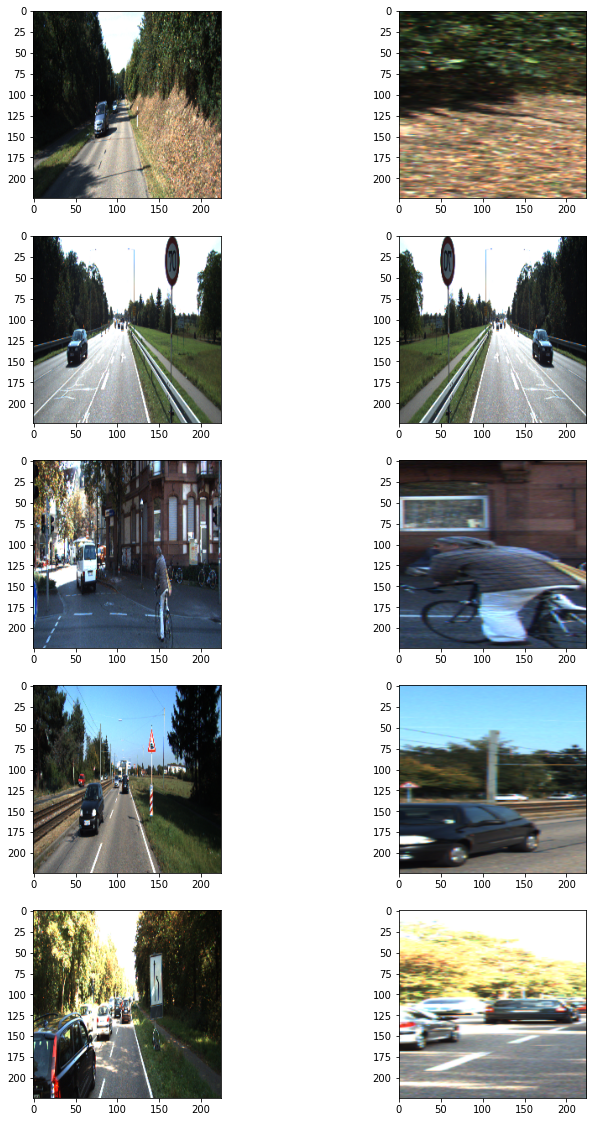

In [11]:
path = '/content/drive/MyDrive/아이펠/GOING DEEPER/data/semantic_segmentation/data'
dir_path = path + '/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)      # 애스터리스크 2개 사용 (**) : dict를 unpack한다. value값만 가져옴
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

- `tf.keras.utils.Sequence`를 상속받은 generator 형태로 데이터를 구성한다.
- U-Net++는 메모리 사용량이 U-Net보다 많아지기 때문에, **배치 사이즈를 `16` 👉 `128`**로 변경

In [13]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=128,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [14]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## Step 2. U-Net++ 모델의 구현
U-Net의 모델 구조와 소스코드를 면밀히 비교해 보다 보면, U-Net++를 어떻게 구현할 수 있을지에 대한 방안을 떠올릴 수 있을 것입니다. 이 과정을 통해 U-Net 자체에 대한 이해도도 증진될 것입니다. 그 외 적절히 U-Net의 백본 구조, 기타 파라미터 변경 등을 통해 추가적인 성능 향상이 가능할 수도 있습니다.

**모델 구조 만들기**

시맨틱 세그멘테이션을 위한 모델을 만들어주세요. 세그멘테이션 모델 중 구조상 비교적 구현이 단순한 `U-Net`을 구현해 봅시다.

<br>

이때 입력 이미지의 크기는 위에서 만든 데이터셋에 맞춰서 만들어주세요.

<br>

사용에 필요한 레이어와 연산은 다음과 같습니다. 그리고 필요에 따라서 Dropout 등의 다른 레이어를 적용해 보세요.

<br>

- `Conv2D`, `Conv2DTranspose`, `MaxPooling2D`, `concatenate`

In [ ]:
# 예시코드에서는 U-Net에 패딩을 적용하였습니다. 패딩을 적용하지 않고 구현해도 좋습니다.

def build_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
        
    #Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
    
    #Expanding Path
    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
    up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
    up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
    up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model

## Step 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석
두 모델의 정량적, 정성적 성능을 비교해 봅시다. 시각화, IoU 계산 등을 체계적으로 시도해 보면 차이를 발견하실 수 있을 것입니다.

# 회고

## 공부한 내용

## 루브릭 평가 지표를 맞추기 위해 시도한 것들

|평가문항|상세기준|
|:------|:---|
|1. U-Net을 통한 세그멘테이션 작업이 정상적으로 진행되었는가?|KITTI 데이터셋 구성, U-Net 모델 훈련, 결과물 시각화의 한 사이클이 정상 수행되어 세그멘테이션 결과 이미지를 제출하였다.|
|2. U-Net++ 모델이 성공적으로 구현되었는가?|U-Net++ 모델을 스스로 구현하여 학습 진행 후 세그멘테이션 결과까지 정상 진행되었다.|
|3. U-Net과 U-Net++ 두 모델의 성능이 정량적/정성적으로 잘 비교되었는가?|U-Net++ 의 세그멘테이션 결과 사진과 IoU 계산치를 U-Net과 비교하여 우월함을 확인하였다.|

## 어려웠던 점

